In [1]:
"""
action_geometry_demo.ipynb
Sam & Jane 2024 

conda activate action-python3
"""

'\naction_geometry_demo.ipynb\nSam & Jane 2024 \n\nconda activate action-python3\n'

In [2]:
import numpy as np
from scipy.stats import rankdata, spearmanr
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
roi_dir = 'fmri/cv_rdm'
code_dir = 'scripts'
rdm_dir = 'RDMs'

In [4]:
rdm_names = ['motion', 'gaze', 'nonverb', 'verb', 'scene',
             'person', 'object', 'sociality', 'transitivity']
rdms = {name: np.load(f'{rdm_dir}/{name}_rdm.npy') for name in rdm_names}

reorder = np.load(f'{code_dir}/reorder_conditions.npy')
labels = np.load(f'{code_dir}/sparse_ordered_labels.npy').astype(str)

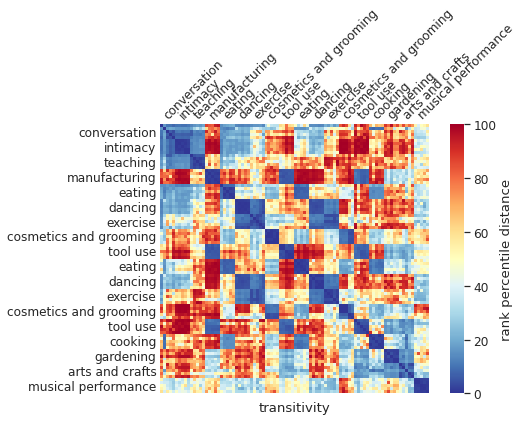

In [5]:
rdm_name = 'transitivity'
rdm = rdms[rdm_name]

sns.set(font_scale=1.1)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(squareform(rankdata(rdm) / len(rdm) * 100)[reorder][:, reorder],
                 vmin=0, vmax=100, square=True, cmap='RdYlBu_r',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'label': 'rank percentile distance'})
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both', length=0)
plt.xticks(rotation=45, ha='left')
plt.yticks(va='top')
plt.title(rdm_name, va='top', y=-.05)
plt.tight_layout()
plt.show()

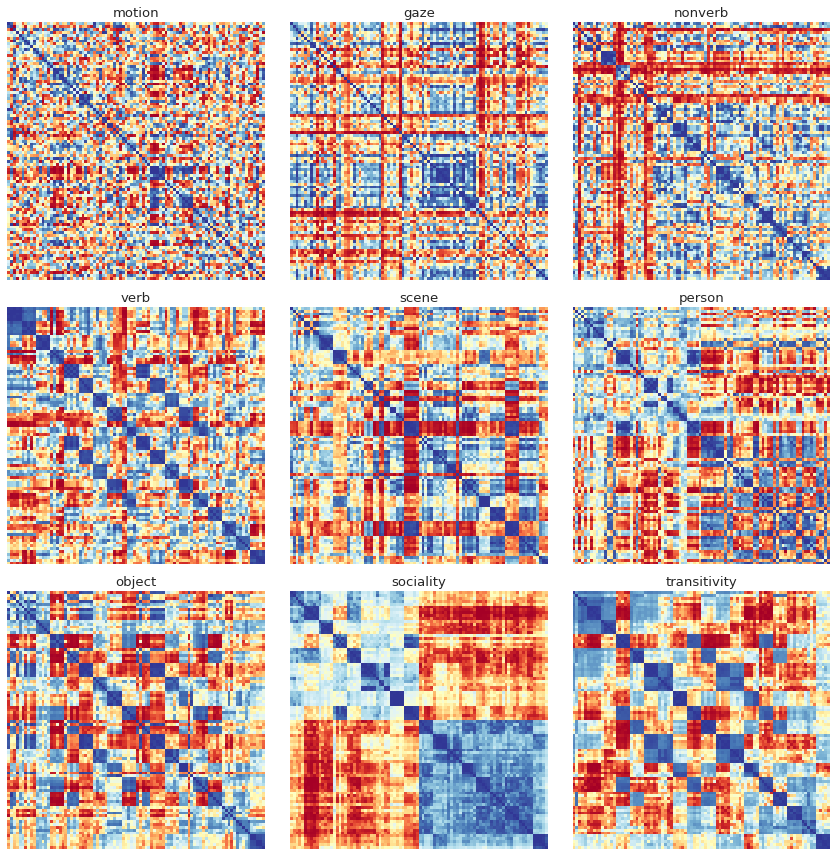

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for rdm_name, ax in zip(rdm_names, axs.ravel()):
    sns.heatmap(squareform(rankdata(rdms[rdm_name]) / len(rdms[rdm_name]) * 100)[reorder][:, reorder],
                vmin=0, vmax=100, square=True, cmap='RdYlBu_r', cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    ax.set_title(rdm_name)
plt.tight_layout()

In [7]:
participants = {'1': 'sid000021', '2': 'sid000120',
                '3': 'sid000005', '4': 'sid000029',
                '5': 'sid000010', '6': 'sid000013',
                '7': 'sid000020', '8': 'sid000024',
                '9': 'sid000009', '10': 'sid000012',
                '11': 'sid000034', '12': 'sid000007',
                '13': 'sid000416', '14': 'sid000433',
                '15': 'sid000134', '16': 'sid000522',
                '17': 'sid000114', '18': 'sid000102',
                '19': 'sid000499', '20': 'sid000142',
                '21': 'sid000535', '22': 'sid000278',
                '23': 'sid000052'}

In [8]:
hemis = ['lh', 'rh']
roi_names = ['EV', 'LO', 'VT', 'pSTS', 'TPJ','PPC', 'AIP', 'VPM', 'PMC']
rois = {}
for roi_name in roi_names:
    rois[roi_name] = {}
    for hemi in hemis:
        rois[roi_name][hemi] = []
        for p in participants:
            rois[roi_name][hemi].append(squareform(
                np.load(f'{roi_dir}/cv_rdm_sub-{participants[p]}_{hemi}_{roi_name}-v2.npy'),
                checks=False))
        rois[roi_name][hemi] = np.vstack(rois[roi_name][hemi])

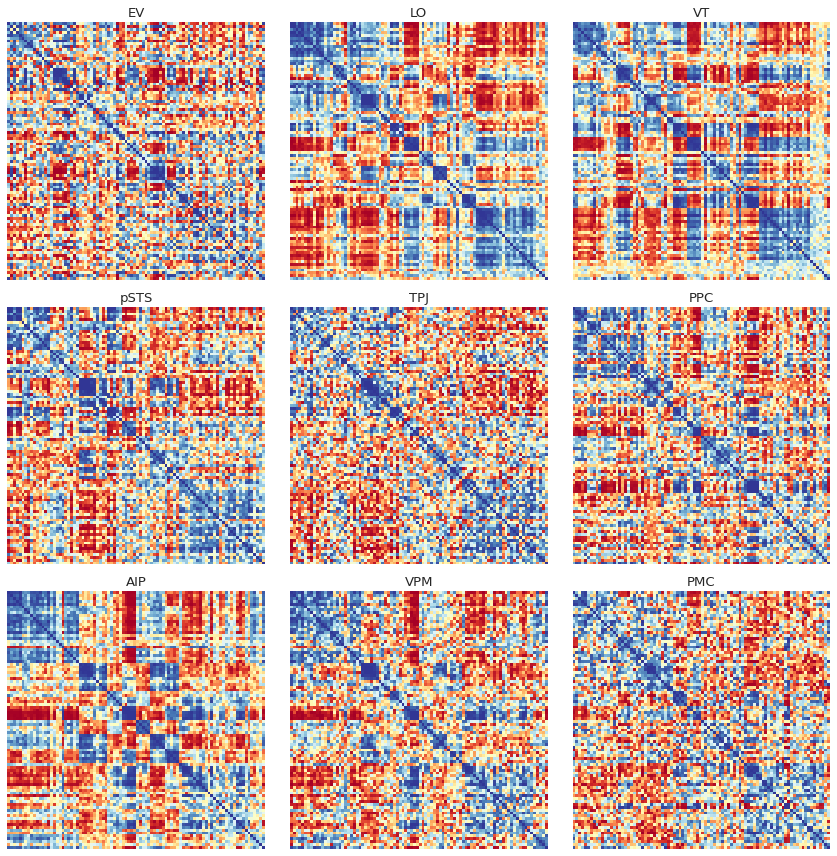

In [9]:
hemi = 'lh'
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for roi_name, ax in zip(roi_names, axs.ravel()):
    sns.heatmap(squareform(rankdata(np.mean(rois[roi_name][hemi], axis=0)) / 
                           len(np.mean(rois[roi_name][hemi], axis=0)) * 100)[reorder][:, reorder],
                vmin=0, vmax=100, square=True, cmap='RdYlBu_r', cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    ax.set_title(roi_name)
plt.tight_layout()

In [10]:
n_participants = len(participants.keys())
results = {'ROI': [], 'model': [], 'hemisphere': [], 'Spearman r': []}

for roi_name in roi_names:
    for hemi in hemis:
        for rdm_name in rdm_names:
            rs = []
            for p in np.arange(n_participants):
                r = spearmanr(rdms[rdm_name], rois[roi_name][hemi][p])[0]
                rs.append(r)
            results['ROI'].extend([roi_name] * n_participants)
            results['model'].extend([rdm_name] * n_participants)
            results['hemisphere'].extend([hemi] * n_participants)
            results['Spearman r'].extend(rs)
        
results = pd.DataFrame(results)

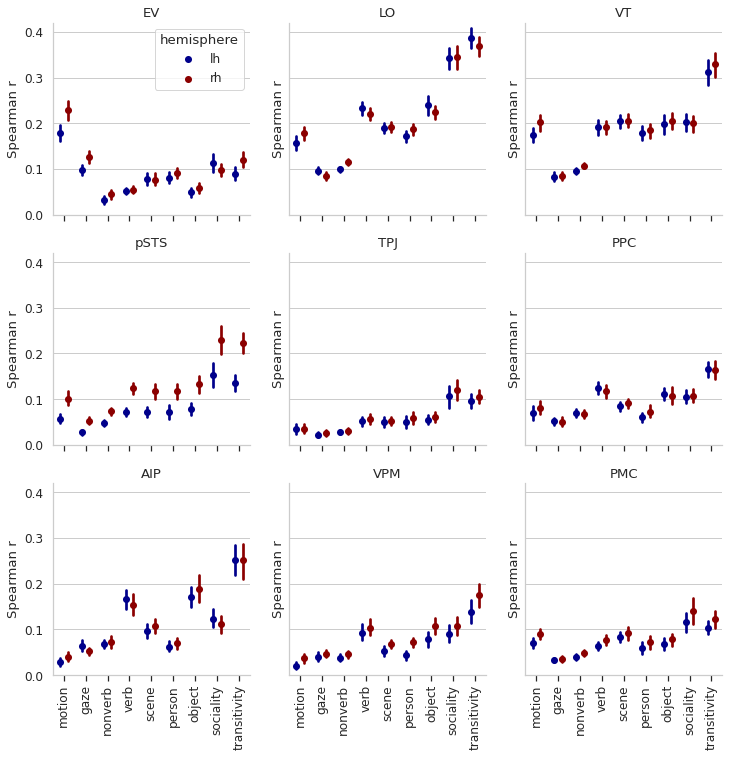

In [11]:
sns.set(style='whitegrid', font_scale=1.1,
        rc={'xtick.bottom': True})
fig, axs = plt.subplots(3, 3, figsize=(12, 12),
                        sharex=True, sharey=True)
for roi_name, ax in zip(roi_names, axs.ravel()):
    sns.pointplot(x='model', y='Spearman r', hue='hemisphere',
                  data=results[results['ROI'] == roi_name],
                  join=False, scale=.8, ax=ax, dodge=.35,
                  palette=sns.color_palette(['darkblue', 'darkred'], 2))
    ax.set(ylim=(0, .42), title=roi_name, xlabel=None)
    ax.set_xticklabels(rdm_names, rotation=90)
    if roi_name != 'EV':
        ax.get_legend().remove()
sns.despine()